# Comparison of different clustering algorithms
We will play around with those three algorithms on different datasets, and see how those algorithms perform in different circumstances.

In [35]:
# download louvain package
!pip install louvain python-igraph leidenalg graphtools

In [36]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=14)

import sklearn
import sklearn.cluster
import sklearn.datasets

import louvain
import graphtools as gt

import warnings
warnings.filterwarnings("ignore")

## Dataset generation
First, we need to generate different datasets for clustering. We will use three datasets in $\mathbb{R}^2$: (**Note that the real data is usually high-dimensional, we use 2 dimensional dataset here just for better visualization**).

* **Double-circles**: Dataset of the shape of two circles with the same center but different radius.

* **Regular blobs**: several regular blobs, regular cluster shape.

* **Uniform distribution**: Data generated from uniform distribution.

You don't need to do anything at this step, since we have already implemented it for you.

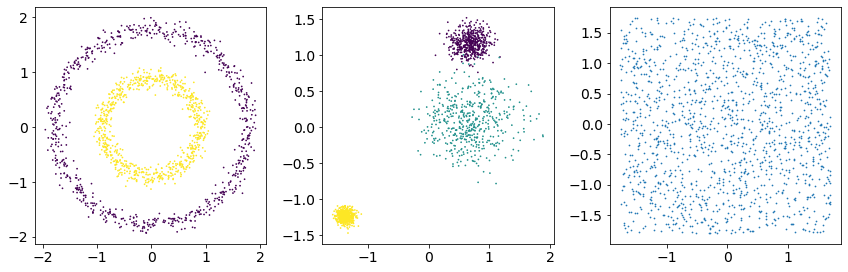

In [37]:
np.random.seed(0)
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500

# Circles
noisy_circles = sklearn.datasets.make_circles(
    n_samples=n_samples, 
    # Scale factor between inner and outer circle
    factor=.5,
    # Gaussian noise added to each point
    noise=.05)

# Uniform square
no_structure = (np.random.uniform(size=(n_samples, 2)), None)

# blobs with varied variances
varied = sklearn.datasets.make_blobs(n_samples=n_samples,
                                     cluster_std=[1.0, 2.5, 0.5],
                                     random_state=8)

# ============
# Associate each dataset with the correct # of clusters
# ============

default_base = {'n_clusters': 3}

generated_datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (varied,      {}),
    (no_structure, {})]
  
fig, axes = plt.subplots(1,3,figsize=(12,4))

for i, (dataset, _) in enumerate(generated_datasets):
    ax = axes[i]
    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = sklearn.preprocessing.StandardScaler().fit_transform(X)
    ax.scatter(X[:,0], X[:,1], c=y, s = 0.5)
    
fig.tight_layout()

## K-means algorithm
You need to fill in the blank area of the k-means algorithm below. You will implement this part using `sklearn`.

**Useful tutorial**:
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


In [38]:
def kmeans_skl(X, n_clusts):
    """\
    Kmeans algorithm

    Parameters:
    -----------
    X:
      dataset, numpy array of the shape (n_samples, n_features)
    n_clusts:
      number of clusters
    
    Return:
    ----------
    group:
      group identity of the clustering result, numpy array of the shape (n_samples,). 
      e.g, if there are three data samples clustered into two groups, the return should be something like, numpy.array([0,1,1])
    """
    # implement kmeans algorithm using sklearn
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusts).fit(X)
    groups = kmeans.labels_
    return groups

## Spectral clustering algorithm
You need to fill in the blank area of the spectral clustering algorithm below. You will implement this part using `sklearn`.

**Useful tutorial**:
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

**Note**:
* Make sure to set the `affinity` in spectral clustering function to `"nearest_neighbors"`. The default setting in sklearn was `"rbf"`, which will not produce a very good result.

In [39]:
def spectral_skl(X, n_clusts):
    """\
    spectral clustering algorithm

    Parameters:
    -----------
    X:
      dataset, numpy array of the shape (n_samples, n_features)
    n_clusts:
      number of clusters
    
    Return:
    ----------
    group:
      group identity of the clustering result, numpy array of the shape (n_samples,). 
      e.g, if there are three data samples clustered into two groups, the return should be something like, numpy.array([0,1,1])
    """
    # implement spectral clustering algorithm using sklearn
    spec_cluster = sklearn.cluster.SpectralClustering(n_clusters=n_clusts, affinity = "nearest_neighbors").fit(X)
    groups = spec_cluster.labels_

    return groups

## Leiden algorithm
Leiden algorithm is a graph based algorithm, instead of specifying the number of clusters, leiden algorithm use resolution to control the size of clusters.

You don't need to do anything here, we have already implemented leiden algorithm for you, but you can play around with the resolution term to see how this will affect the number of clusters

In [40]:
def leiden(X, resolution=0.01):
    """\
    leiden clustering algorithm.

    Parameters:
    -----------
    X:
      dataset, numpy array of the shape (n_samples, n_features)
    resolution:
      resolution term
    
    Return:
    ----------
    group:
      group identity of the clustering result, numpy array of the shape (n_samples,). 
      e.g, if there are three data samples clustered into two groups, the return should be something like, numpy.array([0,1,1])
    """ 
    G = gt.Graph(X)
    G_igraph = G.to_igraph()
    part = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                                  weights="weight", resolution_parameter=resolution)
    groups = np.array(part.membership)
    return groups

## Test the algorithms in different datasets
We will test the algorithms in different datasets. Run the code below and see how the algorithms perform under different circumstances. Submit the plots that you generate. Discuss with your collaborator and briefly discribe what you find in you submission.


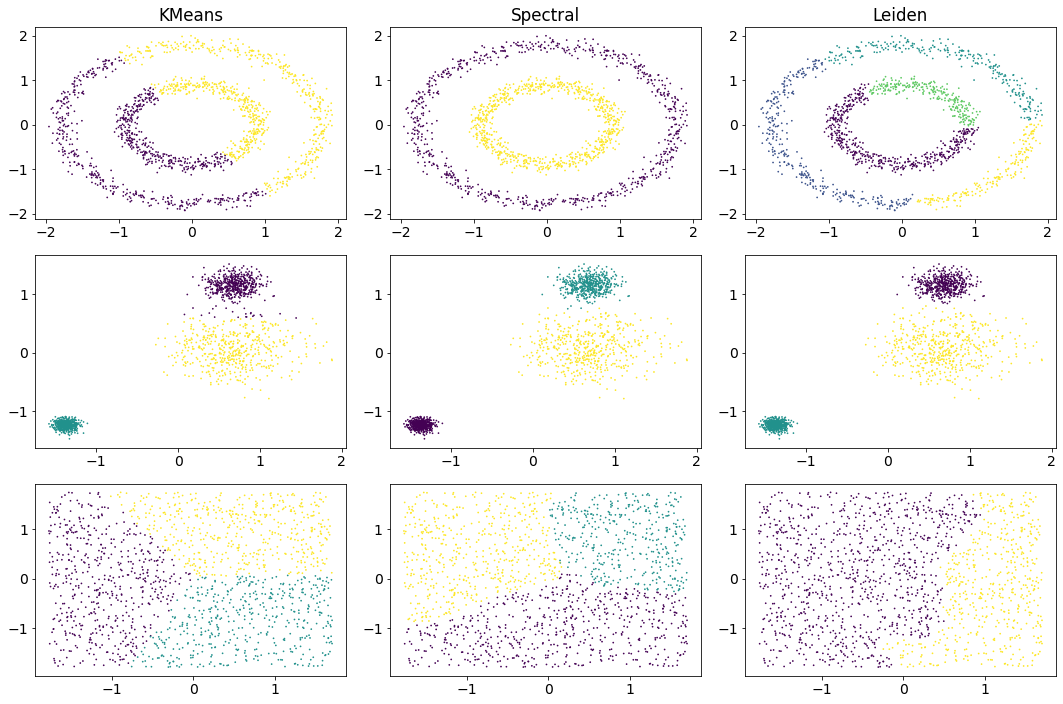

In [43]:
fig, axes = plt.subplots(3,3, figsize=(15, 10))
plot_title = True

titles = ['KMeans', 'Spectral', 'Leiden']

# loop through all three datasets
for i_dataset, (dataset, cluster_params) in enumerate(generated_datasets):
    
    params = default_base.copy()
    params.update(cluster_params)

    X, y = dataset
    
    # normalize dataset
    X = sklearn.preprocessing.StandardScaler().fit_transform(X)
    
    # ============
    # Run clustering algorithms
    # ============
    clusters = []
    
    # KMeans
    clusters.append(kmeans_skl(X, n_clusts = params['n_clusters']))
    
    # Spectral Clustering
    clusters.append(spectral_skl(X, n_clusts = params['n_clusters']))
    
    # Leiden
    clusters.append(leiden(X, resolution = 0.01))
 
    # ============
    # Plot clustering results
    # ============
    row_axes = axes[i_dataset]
    
    for i, ax in enumerate(row_axes.flatten()):
        curr_cluster = clusters[i]
        if plot_title:
            curr_title = '{}'.format(titles[i])
        else:
            curr_title = None
            
        ax.scatter(X[:,0], X[:,1], c=curr_cluster, s = 0.5)
        ax.set_title(curr_title)

    plot_title=False
fig.tight_layout()

## Running time
Next we will test the running time of the algorithms with datasets of different sizes. We will use the **Regular blobs** shaped dataset with different number of samples: 1000, 5000, 10000 and see how the running time changes. Report your running times. Discuss with your collaborator about what you see, briefly analyze the result in your submission.


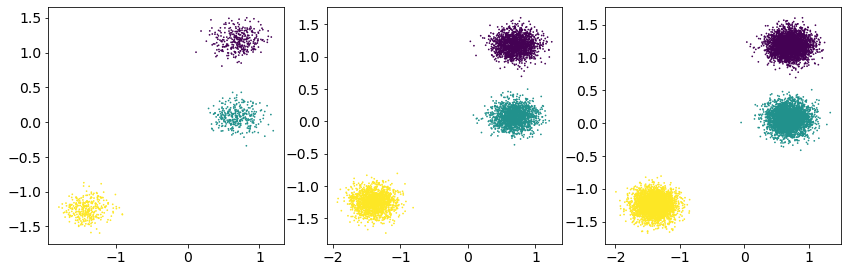

In [ ]:
np.random.seed(0)

# generated datasets
generated_datasets = [(sklearn.datasets.make_blobs(n_samples=n_samples, random_state=8, cluster_std=1), n_samples) for n_samples in [1000, 5000, 10000]]
  
fig, axes = plt.subplots(1,3,figsize=(12,4))

for i, (dataset, _) in enumerate(generated_datasets):
    ax = axes[i]
    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = sklearn.preprocessing.StandardScaler().fit_transform(X)
    ax.scatter(X[:,0], X[:,1], c=y, s = 0.5)
    
fig.tight_layout()

dataset: 0, number of samples: 1000
	 running time for k-means(sec): 0.02146601676940918
	 running time for spectral clustering(sec): 0.2518143653869629
	 running time for leiden algorithm(sec): 0.13764405250549316
dataset: 1, number of samples: 5000
	 running time for k-means(sec): 0.05347132682800293
	 running time for spectral clustering(sec): 2.3372488021850586
	 running time for leiden algorithm(sec): 0.370189905166626
dataset: 2, number of samples: 10000
	 running time for k-means(sec): 0.08298444747924805
	 running time for spectral clustering(sec): 6.753821849822998
	 running time for leiden algorithm(sec): 0.638094425201416


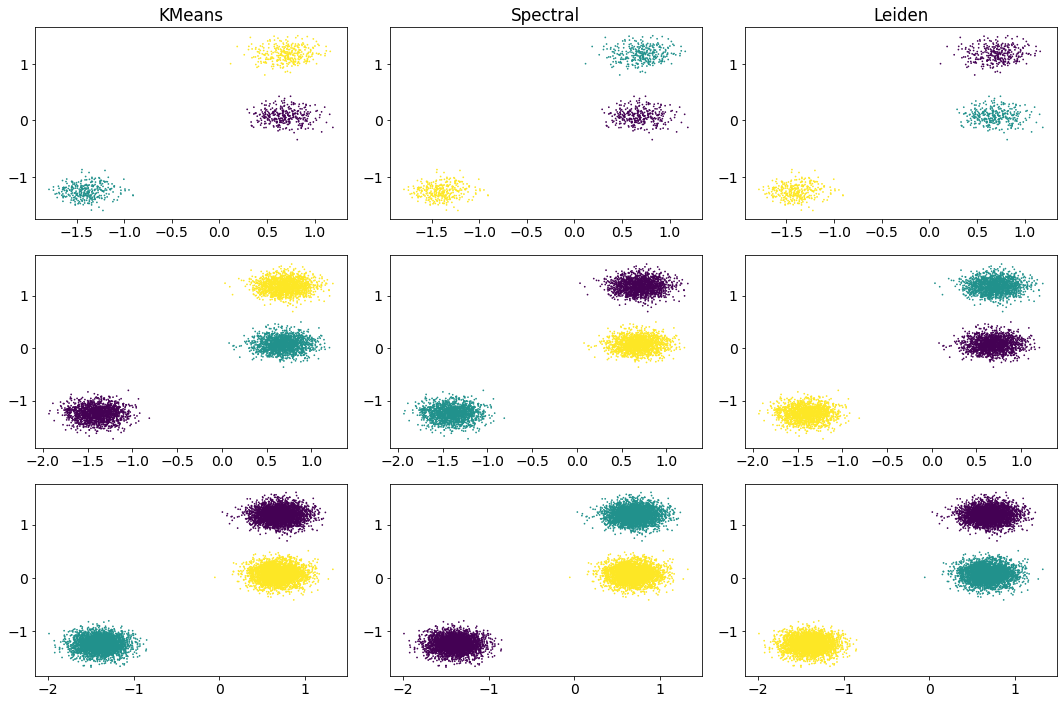

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(15, 10))
plot_title = True


titles = ['KMeans', 'Spectral', 'Leiden']

# loop through all three datasets
for i_dataset, (dataset, n_samples) in enumerate(generated_datasets):
    print("dataset: "+str(i_dataset)+", number of samples: " + str(n_samples))
    
    params = default_base.copy()
    params.update(cluster_params)

    X, y = dataset
    
    # normalize dataset
    X = sklearn.preprocessing.StandardScaler().fit_transform(X)
    
    # ============
    # Run clustering algorithms
    # ============
    clusters = []
    
    
    # KMeans
    tic = time.time()
    clusters.append(kmeans_skl(X, n_clusts = 3))
    print("\t running time for k-means(sec):", time.time() - tic)
    
    # Spectral Clustering
    tic = time.time()
    clusters.append(spectral_skl(X, n_clusts = 3))
    print("\t running time for spectral clustering(sec):", time.time() - tic)
    
    # Leiden
    tic = time.time()
    clusters.append(leiden(X, resolution = 0.01))
    print("\t running time for leiden algorithm(sec):", time.time() - tic)

    # ============
    # Plot clustering results
    # ============
    row_axes = axes[i_dataset]
    
    for i, ax in enumerate(row_axes.flatten()):
        curr_cluster = clusters[i]
        if plot_title:
            curr_title = '{}'.format(titles[i])
        else:
            curr_title = None
            
        ax.scatter(X[:,0], X[:,1], c=curr_cluster, s = 0.5)
        ax.set_title(curr_title)
    


    plot_title=False
fig.tight_layout()

## Additional reading:
* **SpectralNet** is a fast implementation of spectral clustering algorithm with deep neural network. It has the advantage of spectral clustering and also scales well to large datasets: https://arxiv.org/abs/1801.01587  

* **Quora discussion** about the pros and cons of spectral clustering and k-means: https://www.quora.com/What-are-the-advantages-of-spectral-clustering-over-k-means-clustering
